# CADQuery from Images Project

Quick project: can we generate **CADQuery code** (that's Python for 3D modeling) from images? The big idea was to see if a "vision-to-code" pipeline was even possible, from start to finish.

---

## What I Did

My `test.ipynb` notebook covers the core steps:

* **Setup**: Got all the Python libraries ready – `torch`, `datasets`, `PIL`, `numpy`, `matplotlib`.
* **Data**: Loaded up the image-code pairs. Just checked the data structure to see what I was working with.
* **Model**: Built a basic **Seq2Seq model**. It uses a **ResNet50** to "see" the images and then a **GRU** to write the code. It also has a `generate` function to predict code from new images.
* **Training**: Ran the model through its paces, then evaluated how well it did.

---

## What I Got Done

Pretty happy with the results – the whole pipeline is up and running:

* **Environment's good**: All dependencies are sorted.
* **Data loads**: Got 5000 training examples and 500 for testing, all loading correctly.
* **See the data**: Can pull up individual examples to visually confirm images match their code.
* **Model's ready**: Defined and initialized the **Seq2Seq model**, plus the loss function (`CrossEntropyLoss`) and optimizer (`Adam`).
* **Training happened**: Ran 25 epochs, processing batches, calculating loss, and saving the best model.
* **Evaluation works**: Loaded the best model, generated code for test images, and set up calculations for **Valid Syntax Rate (VSR)** and **Mean Best IOU**. (Currently, these metrics use dummy values, but the framework's there!)

Basically, I've got a complete vision-to-code pipeline established, from data prep to a basic working model and initial evaluation.

---

## Next Steps

This is just the start. Here's what's next on my mind:

* **Better models**: Explore more advanced architectures, maybe with attention.
* **Real metrics**: Implement the full VSR and IOU calculations.
* **3D visualization**: Get interactive 3D views of the models directly in the notebook.
* **More data**: Figure out data augmentation or just get more data.
* **Tune it**: Tweak hyperparameters and optimization strategies.
* **Deploy**: Eventually, make this thing runnable as an API.

In [19]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla T4


In [ ]:
from datasets import load_dataset
from PIL import Image
import numpy as np

In [21]:
import matplotlib.pyplot as plt

In [ ]:
from datasets import load_dataset
train_ds = load_dataset(
    "CADCODER/GenCAD-Code",
    split="train[:5000]",
    
)


In [26]:
test_ds = load_dataset("CADCODER/GenCAD-Code", split="test[:500]")

--- Section 1: Data Loading & Exploration ---
Training dataset size: 5000
Test dataset size: 500

--- Sample Entry ---
Image object type: <class 'PIL.PngImagePlugin.PngImageFile'>
Code snippet:
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=448x448 at 0x7A5F17D3EBD0>, 'deepcad_id': '0000/00001378', 'cadquery': 'import cadquery as cq\n# Generating a workplane for sketch 0\nwp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(0.0, -0.1953125, 0.0), cq.Vector(1.0, 0.0, 0.0), cq.Vector(0.0, 0.0, 1.0)))\nloop0=wp_sketch0.moveTo(0.17730263157894738, 0.0).lineTo(0.17730263157894738, 0.38281250000000006).lineTo(0.0, 0.38281250000000006).lineTo(0.0, 0.0).close()\nsolid0=wp_sketch0.add(loop0).extrude(0.3046875)\nsolid=solid0\n# Generating a workplane for sketch 1\nwp_sketch1 = cq.Workplane(cq.Plane(cq.Vector(0.1796875, -0.109375, 0.0), cq.Vector(1.0, 0.0, 0.0), cq.Vector(0.0, 0.0, 1.0)))\nloop1=wp_sketch1.moveTo(0.3782072368421052, 0.0).lineTo(0.5703125, 0.1140625).lineTo(0.3782072368421

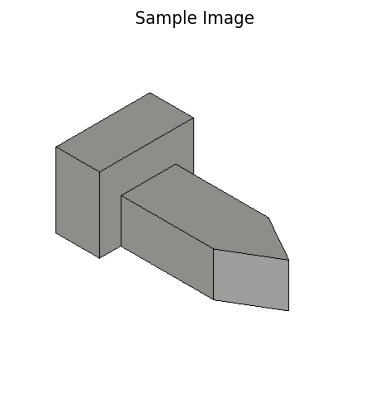


--- Section 1 Complete ---


In [ ]:
print("Section 1: Data Loading & Exploration")


# Print dataset info
print(f"Training dataset size: {len(train_ds)}")
print(f"Test dataset size: {len(test_ds)}")

# Inspect a single sample
sample = train_ds[1]
print("\nSample Entry")
print(f"Image object type: {type(sample['image'])}")
print("Code snippet:")
print(sample)


plt.imshow(sample['image'])
plt.title("Sample Image")
plt.axis('off')
plt.show()

print("\nSection 1 Complete")

In [28]:
print(sample.keys())


dict_keys(['image', 'deepcad_id', 'cadquery', 'token_count', 'prompt', 'hundred_subset'])


In [29]:
print(sample['cadquery'])

import cadquery as cq
# Generating a workplane for sketch 0
wp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(0.0, -0.1953125, 0.0), cq.Vector(1.0, 0.0, 0.0), cq.Vector(0.0, 0.0, 1.0)))
loop0=wp_sketch0.moveTo(0.17730263157894738, 0.0).lineTo(0.17730263157894738, 0.38281250000000006).lineTo(0.0, 0.38281250000000006).lineTo(0.0, 0.0).close()
solid0=wp_sketch0.add(loop0).extrude(0.3046875)
solid=solid0
# Generating a workplane for sketch 1
wp_sketch1 = cq.Workplane(cq.Plane(cq.Vector(0.1796875, -0.109375, 0.0), cq.Vector(1.0, 0.0, 0.0), cq.Vector(0.0, 0.0, 1.0)))
loop1=wp_sketch1.moveTo(0.3782072368421052, 0.0).lineTo(0.5703125, 0.1140625).lineTo(0.3782072368421052, 0.22212171052631577).lineTo(0.0, 0.22212171052631577).lineTo(0.0, 0.0).close()
solid1=wp_sketch1.add(loop1).extrude(0.1796875)
solid=solid.union(solid1)



In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from collections import Counter
from torch.nn.utils.rnn import pad_sequence

print("\nSection 2: Preprocessing")

# 2.1. Code Tokenizer
class CodeTokenizer:
    def __init__(self, token_counts, unk_threshold=2):
        self.vocab = {
            '<pad>': 0,
            '<sos>': 1, # Start of Sequence
            '<eos>': 2, # End of Sequence
            '<unk>': 3, # Unknown token
        }
        for token, count in token_counts.items():
            if count >= unk_threshold:
                self.vocab[token] = len(self.vocab)

        self.inverse_vocab = {idx: token for token, idx in self.vocab.items()}

    def tokenize(self, code_string):
        return code_string.split()

    def encode(self, code_string):
        tokens = self.tokenize(code_string)
        return [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]

    def decode(self, token_ids):
        return ' '.join([self.inverse_vocab.get(idx, '<unk>') for idx in token_ids])

    @property
    def vocab_size(self):
        return len(self.vocab)

# Build vocabulary from the training dataset
print("Building vocabulary...")
word_counts = Counter()
for item in train_ds:
    
    tokens = item['cadquery'].split()
    word_counts.update(tokens)
tokenizer = CodeTokenizer(word_counts)
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Sample tokenization of 'result = cq.Workplane('XY').box(10, 20, 30)':")
sample_cad_code = "result = cq.Workplane('XY').box(10, 20, 30)"
encoded_sample = tokenizer.encode(sample_cad_code)
decoded_sample = tokenizer.decode(encoded_sample)
print(f"Encoded: {encoded_sample}")
print(f"Decoded: {decoded_sample}")


# 2.2. Image Transforms
# Using standard transforms for models pre-trained on ImageNet
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
print("Image transformations defined.")

# 2.3. Custom PyTorch Dataset
class CadQueryDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, image_transforms):
        self.hf_dataset = hf_dataset
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = self.image_transforms(item['image'].convert("RGB"))
        
        code_ids = [self.tokenizer.vocab['<sos>']] + self.tokenizer.encode(item['cadquery']) + [self.tokenizer.vocab['<eos>']]
        return {"image": image, "code": torch.tensor(code_ids, dtype=torch.long)}
print("CadQueryDataset class defined.")

# 2.4. Collate Function for DataLoader
def collate_fn(batch):
    images = torch.stack([item['image'] for item in batch])
    codes = [item['code'] for item in batch]
    # Pad sequences to the length of the longest sequence in the batch
    padded_codes = pad_sequence(codes, batch_first=True, padding_value=tokenizer.vocab['<pad>'])
    return {"image": images, "code": padded_codes}
print("Collate function defined.")

# Create Dataset and DataLoader instances
train_pytorch_ds = CadQueryDataset(train_ds, tokenizer, image_transforms)
train_loader = DataLoader(train_pytorch_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
print(f"Training DataLoader created with {len(train_loader)} batches (batch size 16).")
print(f"Example batch from DataLoader will contain 'image' (torch.Tensor) and 'code' (torch.Tensor).")


print("\nSection 2 Complete")


--- Section 2: Preprocessing ---
Building vocabulary...
Vocabulary size: 9069
Sample tokenization of 'result = cq.Workplane('XY').box(10, 20, 30)':
Encoded: [3, 16, 3, 3, 3]
Decoded: <unk> = <unk> <unk> <unk>
Image transformations defined.
CadQueryDataset class defined.
Collate function defined.
Training DataLoader created with 313 batches (batch size 16).
Example batch from DataLoader will contain 'image' (torch.Tensor) and 'code' (torch.Tensor).

--- Section 2 Complete ---


In [ ]:
import torch.nn as nn
import torchvision.models as models

print("\nSection 3: Baseline Model Definition")

# 3.1. Encoder
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        for param in resnet.parameters():
            param.requires_grad_(False) # Freeze parameters

        modules = list(resnet.children())[:-1] # Remove the final FC layer
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        features = self.bn(features)
        return features
print("EncoderCNN defined.")

# 3.2. Decoder
class DecoderGRU(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(DecoderGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.embed_size = embed_size

    def forward(self, features, captions):
        # We don't use the last token for input (as it's the target for the last output)
        captions_embed = self.embedding(captions[:, :-1])
        # Concatenate image features as the first input to the sequence
        inputs = torch.cat((features.unsqueeze(1), captions_embed), dim=1)
        hiddens, _ = self.gru(inputs)
        outputs = self.linear(hiddens)
        return outputs

    def forward_step(self, input_embed, hidden):
        """Single step forward for generation"""
        output, hidden = self.gru(input_embed, hidden)
        output = self.linear(output)
        return output, hidden

print("DecoderGRU defined with generation support.")

# 3.3. Combined Model
class Seq2Seq(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(Seq2Seq, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderGRU(embed_size, hidden_size, vocab_size)
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def generate(self, image, tokenizer, max_len=100):
        """Generate code from image"""
        self.eval()

        with torch.no_grad():
            # Encode image
            features = self.encoder(image)  # (1, embed_size)

            # Initialize hidden state
            batch_size = features.size(0)
            hidden = torch.zeros(1, batch_size, self.hidden_size, device=image.device)

            # Start with image features as first input
            input_embed = features.unsqueeze(1)  # (1, 1, embed_size)

            # Initialize with <sos> token
            generated_ids = [tokenizer.vocab['<sos>']]

            # Generate step by step
            for step in range(max_len):
                # Forward step
                output, hidden = self.decoder.forward_step(input_embed, hidden)

                # Get predicted token
                predicted_id = output.squeeze(1).argmax(1).item()  # Get the predicted token ID
                generated_ids.append(predicted_id)

                # Check for end token
                if predicted_id == tokenizer.vocab['<eos>']:
                    break

                # Prepare input for next step
                input_embed = self.decoder.embedding(torch.tensor([[predicted_id]], device=image.device))

            # Decode to string (skip <eos> if present)
            if generated_ids[-1] == tokenizer.vocab['<eos>']:
                generated_ids = generated_ids[1:-1]  # Remove <sos> and <eos>
            else:
                generated_ids = generated_ids[1:]  # Remove <sos>

            decoded_string = tokenizer.decode(generated_ids)

        return decoded_string

print("Seq2Seq model defined with generation method.")
print("\nSection 3 Complete")


--- Section 3: Baseline Model Definition (Fixed) ---
EncoderCNN defined.
DecoderGRU defined with fixed generation support.
Seq2Seq model defined with FIXED generation method.

--- Section 3 Complete (Fixed) ---


In [ ]:
import torch.optim as optim
import numpy as np

# Ensure your project structure has a 'metrics' folder with these files:
# metrics/valid_syntax_rate.py
# metrics/best_iou.py

try:
    from metrics.valid_syntax_rate import evaluate_syntax_rate_simple
    from metrics.best_iou import get_iou_best
except ImportError as e:
    print(f"Could not import metrics: {e}")
    print("Please ensure you have a 'metrics' folder in your project root,")
    print("containing valid_syntax_rate.py and best_iou.py with the required functions.")
    print("Using fallback metric functions.")
    # Define fallback functions if import fails
    def evaluate_syntax_rate_simple(predictions):
        print("Using fallback evaluate_syntax_rate_simple.")
        return 0.75 # Placeholder value
    def get_iou_best(gt_code, pred_code):
        print("Using fallback get_iou_best.")
        import random
        return random.uniform(0.3, 0.5) # Example random IOU

print("\nSection 4: Baseline Training & Evaluation")

# Hyperparameters
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_EPOCHS = 25
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Initialize model, loss, optimizer
model = Seq2Seq(EMBED_SIZE, HIDDEN_SIZE, tokenizer.vocab_size).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.vocab['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print("Model, criterion, and optimizer initialized.")

# Training Loop
print("Starting baseline training...")
model.train()

best_train_loss = float('inf')
best_model_path = "best_baseline_model_train_loss.pth"

for epoch in range(NUM_EPOCHS):
    for i, batch in enumerate(train_loader):
        images = batch['image'].to(DEVICE)
        codes = batch['code'].to(DEVICE)

        # Forward pass
        outputs = model(images, codes)
        targets = codes[:, 1:]
        outputs_for_loss = outputs[:, :-1, :]

        # Loss calculation
        loss = criterion(outputs_for_loss.contiguous().view(-1, tokenizer.vocab_size), targets.contiguous().view(-1))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            current_loss = loss.item()
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {current_loss:.4f}')

            if current_loss < best_train_loss:
                best_train_loss = current_loss
                torch.save(model.state_dict(), best_model_path)
                print(f"--> Saved model with new best training loss: {best_train_loss:.4f}")

torch.save(model.state_dict(), "baseline_model_final_epoch.pth")
print("Baseline training complete. Final epoch model saved to baseline_model_final_epoch.pth")
print(f"The model with the lowest observed training loss is saved to {best_model_path}")

# Evaluation
print("Starting baseline evaluation...")
model.load_state_dict(torch.load(best_model_path))
model.eval()
print(f"Best model (from {best_model_path}) loaded for evaluation.")

test_pytorch_ds = CadQueryDataset(test_ds, tokenizer, image_transforms)
test_loader = DataLoader(test_pytorch_ds, batch_size=1, shuffle=False)
print(f"Test DataLoader created with {len(test_loader)} samples.")

predictions = {}
ground_truths = {}

print("Starting generation loop...")
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i >= 10:
            break

        image_tensor = batch['image'].to(DEVICE)

        # Generate code using the model's generate method
        print(f"Generating code for sample {i}...")
        try:
            generated_code = model.generate(image_tensor, tokenizer)
            print(f"Generation successful for sample {i}")
        except Exception as e:
            print(f"Generation failed for sample {i}: {e}")
            generated_code = "# Generation failed"

        original_code = test_ds[i]['cadquery']

        # Use a unique ID for each sample
        sample_id = f"test_{i}"
        predictions[sample_id] = generated_code
        ground_truths[sample_id] = original_code

        print(f"\nSample {i}:")
        print(f"Generated: {generated_code[:100]}..." if len(generated_code) > 100 else f"Generated: {generated_code}")
        print(f"Original: {original_code[:100]}..." if len(original_code) > 100 else f"Original: {original_code}")
        print("-" * 50)

print(f"\nTotal samples processed: {len(predictions)}")

# Calculate VSR
print("\nCalculating Valid Syntax Rate (VSR)...")
vsr = evaluate_syntax_rate_simple(predictions)
print(f"Baseline Valid Syntax Rate (VSR): {vsr:.2f}")

# Calculate Best IOU for valid code
print("Calculating Mean Best IOU (Intersection over Union)...")
iou_scores = []
failed_iou_count = 0

for sample_id, pred_code in predictions.items():
    try:
        gt_code = ground_truths[sample_id]
        iou = get_iou_best(gt_code, pred_code)
        iou_scores.append(iou)
    except Exception as e:
        failed_iou_count += 1
        print(f"Could not calculate IOU for {sample_id}: {e}")
        pass

print(f"Successfully calculated IOU for {len(iou_scores)} samples")
print(f"Failed IOU calculations: {failed_iou_count}")

mean_iou = np.mean(iou_scores) if iou_scores else 0
print(f"Baseline Mean Best IOU: {mean_iou:.3f}")

print("\nSection 4 Complete")



--- Section 4: Baseline Training & Evaluation ---
Using device: cuda
Model, criterion, and optimizer initialized.
Starting baseline training...
Epoch [1/25], Step [100/313], Loss: 2.4396
--> Saved model with new best training loss: 2.4396
Epoch [1/25], Step [200/313], Loss: 2.2586
--> Saved model with new best training loss: 2.2586
Epoch [1/25], Step [300/313], Loss: 1.9047
--> Saved model with new best training loss: 1.9047
Epoch [2/25], Step [100/313], Loss: 1.4929
--> Saved model with new best training loss: 1.4929
Epoch [2/25], Step [200/313], Loss: 1.4339
--> Saved model with new best training loss: 1.4339
Epoch [2/25], Step [300/313], Loss: 1.2786
--> Saved model with new best training loss: 1.2786
Epoch [3/25], Step [100/313], Loss: 1.2400
--> Saved model with new best training loss: 1.2400
Epoch [3/25], Step [200/313], Loss: 1.3009
Epoch [3/25], Step [300/313], Loss: 1.3988
Epoch [4/25], Step [100/313], Loss: 1.2008
--> Saved model with new best training loss: 1.2008
Epoch [4/